# Import data

In [1]:
import pandas as pd
import numpy as np

sales=pd.read_csv("data_processed.csv")
sales

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2018-08-27,44,20.0,53.99,42.38,43.99,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4308,2018-09-03,44,14.0,52.99,53.99,42.38,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4309,2018-09-10,44,22.0,44.99,52.99,53.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4310,2018-09-17,44,28.0,42.99,44.99,52.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# VII/ Extensions


## 1) Prophet

In [2]:
from fbprophet import Prophet
from sklearn.metrics import r2_score
import random
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, ElasticNetCV,ElasticNet
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### What is the Prophet method?

#### Soigmoid and Fourier series

In [3]:
C=4
k=2
m=1

In [4]:
def sigmoid(t):
  return C/(1+np.exp(-k*(t-m)))

In [5]:
df_sigmoid=pd.DataFrame()
df_sigmoid['t']=np.linspace(-2, 4, 50)
df_sigmoid['y']=df_sigmoid['t'].apply(lambda t: sigmoid(t))

In [6]:
slope=k*C/4
df_diff=pd.DataFrame()
df_diff['t']=np.linspace(m-2/k, m+2/k, 50)
df_diff['y']=df_diff['t'].apply(lambda t: C/2+slope*(t-m))

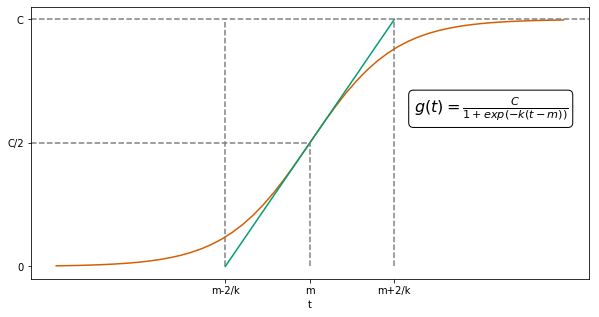

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#set parameters
plt.rcParams.update({'legend.fontsize': 20,'legend.handlelength': 2})
plt.figure(figsize=(10,5))
#plot sigmoid and tangent
plt.plot(df_sigmoid['t'],df_sigmoid['y'], color=sns.color_palette(palette='colorblind')[3])
plt.plot(df_diff['t'],df_diff['y'], color=sns.color_palette(palette='colorblind')[2])
#add lines
plt.axhline(y=C, linestyle='--', color='grey')
plt.axhline(y=C/2, xmin=0, xmax=0.5, linestyle='--', color='grey')
plt.vlines(x=[m-2/k, m+2/k], ymin=0, ymax=C, linestyle='--', color='grey')
plt.vlines(x=[m], ymin=0, ymax=C/2, linestyle='--', color='grey')
#format x-axis
plt.xlabel("t")
locs, labels=plt.xticks()
plt.xticks([m-2/k,m,m+2/k],['m-2/k',  'm',  'm+2/k'])
#format y-axis
locs, labels=plt.yticks()
y_ticks=['0',  'C/2',  'C']
plt.yticks([0,C/2,C], ['0','C/2','C'])
#add formula
plt.annotate(r'$g(t) = \frac{C}{1 + exp(-k(t-m))}  $', xy=(0.69, 0.7), xycoords='figure fraction',
             size=16, ha='left', va='top',
             bbox=dict(boxstyle='round', fc='w'))
#save fiv
plt.savefig("sigmoid.png",dpi=400)

#### Fourier series

In [8]:
df_fourier=pd.DataFrame()
df_fourier['x']=np.linspace(-10, 10, 500)
df_fourier['sin(x)']=df_fourier['x'].apply(lambda x: np.sin(x))
df_fourier['sin(2x)']=df_fourier['x'].apply(lambda x: np.sin(2*x))
df_fourier['sin(x)+sin(2x)']=df_fourier['sin(x)']+df_fourier['sin(2x)']

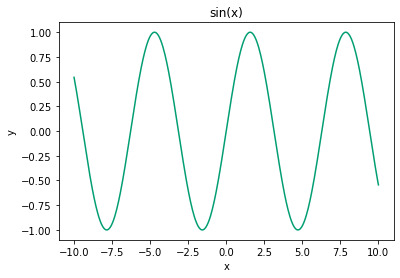

In [9]:
plt.rcParams.update({'font.size': 10})
plt.title('sin(x)')
plt.ylabel("y")
sns.lineplot(x='x', y='sin(x)', data=df_fourier, color=sns.color_palette(palette='colorblind')[2])
plt.savefig("sin(x).png",dpi=400)
plt.show()

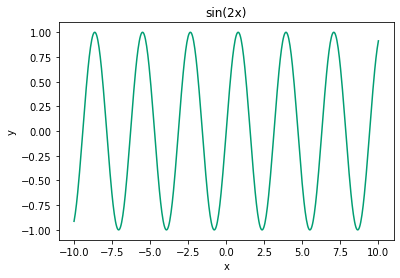

In [10]:
plt.rcParams.update({'font.size': 10})
plt.title('sin(2x)')
plt.ylabel("y")
sns.lineplot(x='x', y='sin(2x)', data=df_fourier, color=sns.color_palette(palette='colorblind')[2])
plt.savefig("sin(2x).png",dpi=400, bbox_inches='tight')
plt.show()

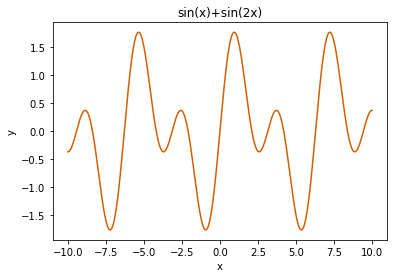

In [11]:
plt.rcParams.update({'font.size': 10})
plt.title('sin(x)+sin(2x)')
plt.ylabel("y")
sns.lineplot(x='x', y='sin(x)+sin(2x)', data=df_fourier, color=sns.color_palette(palette='colorblind')[3])
plt.savefig("sin(x)+sin(2x).png",dpi=400, bbox_inches='tight')
plt.show()

#### Prophet for item 11

In [12]:
df_11=sales[sales.sku==11]
df_11.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
980,2016-11-14,11,17.0,31.99,32.99,32.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
981,2016-11-21,11,17.0,30.99,31.99,32.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
982,2016-11-28,11,31.0,30.99,30.99,31.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
983,2016-12-05,11,19.0,30.99,30.99,30.99,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
984,2016-12-12,11,19.0,29.31,30.99,30.99,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
df_train = pd.DataFrame()
df_train['ds']=list(df_11['week'])[:68]
df_train['y']=list(df_11['weekly_sales'])[:68]
df_train.head()

,ds,y
0,2016-11-14,17.0
1,2016-11-21,17.0
2,2016-11-28,31.0
3,2016-12-05,19.0
4,2016-12-12,19.0


In [14]:
m = Prophet(yearly_seasonality=12)#, interval_width = 0.95)
m.add_country_holidays(country_name='US')
m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods=30, freq = 'W')
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-11-14,27.811693,-11.004020,67.708221,27.811693,27.811693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.446768,0.446768,0.446768,0.0,0.0,0.0,0.446768,0.446768,0.446768,0.0,0.0,0.0,28.258461
1,2016-11-21,28.397633,-7.569803,71.389843,28.397633,28.397633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.504650,1.504650,1.504650,0.0,0.0,0.0,1.504650,1.504650,1.504650,0.0,0.0,0.0,29.902283
2,2016-11-28,28.983572,-28.723980,47.372917,28.983572,28.983572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.804801,-19.804801,-19.804801,0.0,0.0,0.0,-19.804801,-19.804801,-19.804801,0.0,0.0,0.0,9.178771
3,2016-12-05,29.569512,-41.048231,39.484063,29.569512,29.569512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-28.402815,-28.402815,-28.402815,0.0,0.0,0.0,-28.402815,-28.402815,-28.402815,0.0,0.0,0.0,1.166697
4,2016-12-12,30.155452,-11.360490,67.214942,30.155452,30.155452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.743970,-1.743970,-1.743970,0.0,0.0,0.0,-1.743970,-1.743970,-1.743970,0.0,0.0,0.0,28.411481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2018-08-26,82.219925,18.840093,94.620177,82.219895,82.219952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.682537,-25.682537,-25.682537,0.0,0.0,0.0,-25.682537,-25.682537,-25.682537,0.0,0.0,0.0,56.537388
94,2018-09-02,82.805856,5.281105,80.280747,82.805826,82.805886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-40.630979,-40.630979,-40.630979,0.0,0.0,0.0,-40.630979,-40.630979,-40.630979,0.0,0.0,0.0,42.174878
95,2018-09-09,83.391788,33.737955,114.482587,83.391756,83.391820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.123140,-11.123140,-11.123140,0.0,0.0,0.0,-11.123140,-11.123140,-11.123140,0.0,0.0,0.0,72.268649
96,2018-09-16,83.977720,44.142240,124.657405,83.977687,83.977753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

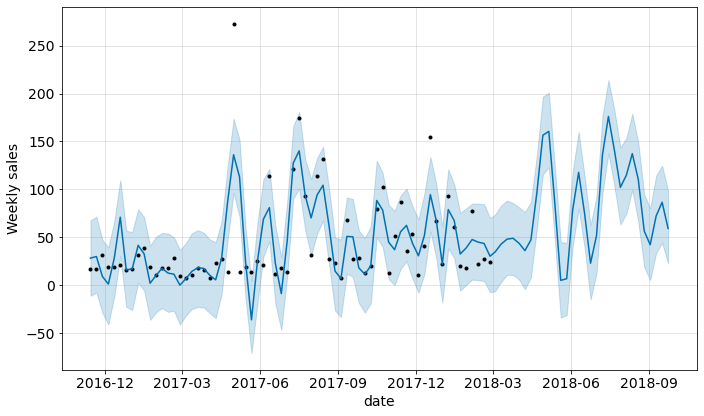

In [16]:
plt.rcParams.update({'font.size': 14})
fig1 = m.plot(forecast)
plt.xlabel("date")
plt.ylabel("Weekly sales")
plt.savefig("prophet_sku_11.png",dpi=400)

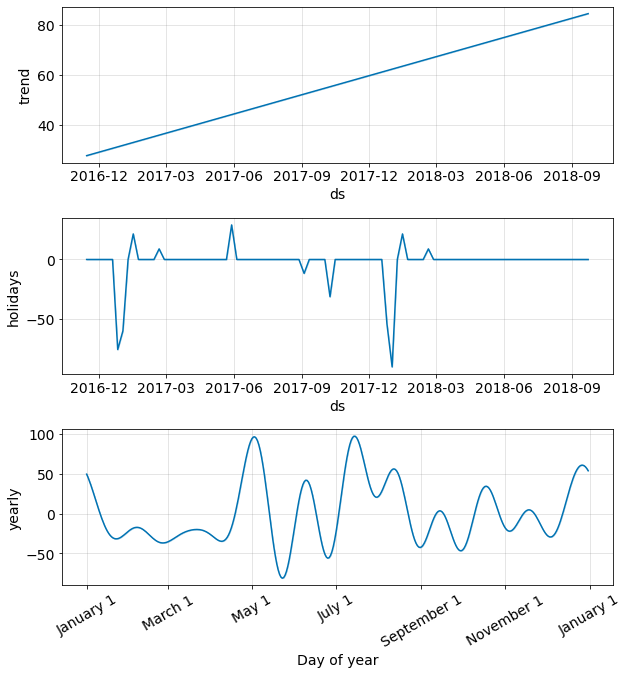

In [17]:
plt.rcParams.update({'font.size': 14})
fig2 = m.plot_components(forecast)
plt.xticks(rotation=30)
plt.savefig("prophet_elements_sku_11.png",dpi=400, bbox_inches='tight')

In [18]:
y_pred=list(forecast['yhat'][-30:])
y_pred

[34.68216664293649,
 42.854531505697864,
 48.04373800714727,
 48.991658495890675,
 43.824413933511764,
 36.072937677105564,
 47.24617910946564,
 96.54391126803921,
 156.4421308650642,
 160.5059777738745,
 86.07271610772074,
 5.063572963765935,
 6.733179008849248,
 78.40980274036534,
 117.76621794204611,
 74.7689383962088,
 22.948850056515198,
 51.756135894089134,
 136.23474538708885,
 176.0542032579728,
 140.7907568862425,
 102.14121906474259,
 114.67572976212156,
 137.23930496532125,
 110.48399484433315,
 56.537387848713095,
 42.17487752875178,
 72.26864880883365,
 86.54423692443687,
 59.23221728174563]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

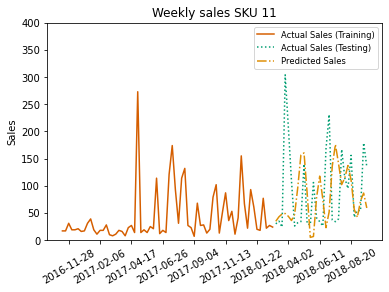

In [19]:
plt.rcParams.update({'font.size': 10})

plt.title('Weekly sales SKU 11')
plt.ylabel("Sales")

plt.plot(df_11.iloc[:68]["week"],df_11.iloc[:68]["weekly_sales"],label="Actual Sales (Training)",color=sns.color_palette(palette='colorblind')[3])
plt.plot(df_11.iloc[68:]["week"],df_11.iloc[68:]["weekly_sales"],label="Actual Sales (Testing)",color=sns.color_palette(palette='colorblind')[2],linestyle="dotted")
plt.plot(df_11.iloc[68:]["week"],y_pred,color=sns.color_palette(palette='colorblind')[1],label="Predicted Sales",linestyle='dashdot')
locs, labels=plt.xticks()
x_ticks = []
plt.xticks(locs[2::10],df_11.week[2::10], rotation=30)
plt.legend(loc='upper right',fontsize='small')
plt.ylim([0,400])

plt.savefig("prophet_sku_11_pred_vs_actual.png",dpi=400, bbox_inches='tight')
plt.show()

### Forecasting with Prophet

In [20]:
res=pd.DataFrame()

#### Univariate Time-series Forecasting

##### Choosing the right seasonality

In [21]:
df_prophet_univariate=sales[['sku','week','weekly_sales']]

skuSet = sales.sku.unique()
skuData = {}
for i in skuSet:
    df_i = df_prophet_univariate[df_prophet_univariate.sku == i]
    skuData[i] = {'X': df_i.week.values,
                  'y': df_i.weekly_sales.values}

In [22]:
X_dict = {}
y_dict = {}

y_test = []
y_train = []

for i in skuSet:

    X_train_i,X_test_i = np.split(skuData[i]["X"], [68])
    y_train_i,y_test_i = np.split(skuData[i]["y"], [68])

    X_dict[i] = {'train': X_train_i, 'test': X_test_i}
    y_dict[i] = {'train': y_train_i, 'test': y_test_i}
    
    y_test += list(y_test_i)
    y_train += list(y_train_i)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
## This script is pretty long to run ##

res_r2=[]

from sklearn.metrics import r2_score

for seas in range(20):

  print('\n Seasonality:',seas)

  y_pred = []
  y_prophet = []

  count=1

  for i in skuSet:
    
    #print('item:',count)
    count+=1
    df_train = pd.DataFrame()
    df_train['ds']=X_dict[i]['train']
    df_train['y']=y_dict[i]['train']

    size_pred=y_dict[i]['test'].shape[0]

    m = Prophet(yearly_seasonality=seas)
    m.add_country_holidays(country_name='US')
    m.fit(df_train)
    future = m.make_future_dataframe(periods=size_pred, freq = 'W')
    forecast = m.predict(future)

    y_pred_i=np.array(forecast['yhat'][-size_pred:])
    y_pred += list(y_pred_i)

    y_prophet_i=np.array(forecast['yhat'])
    y_prophet += list(y_prophet_i)

  print('R2:',r2_score(y_test, np.array(y_pred)))

  res_r2.append(r2_score(y_test, np.array(y_pred)))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Seasonality: 0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.11587830730422854

 Seasonality: 1


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.26539558037872524

 Seasonality: 2


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.2308142214714164

 Seasonality: 3


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.10510106815452591

 Seasonality: 4


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.10424652132099221

 Seasonality: 5


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.024175232327615093

 Seasonality: 6


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.02072176799916703

 Seasonality: 7


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.018223206049411855

 Seasonality: 8


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.03850584402881774

 Seasonality: 9


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: 0.009182909441572074

 Seasonality: 10


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.028449412901325744

 Seasonality: 11


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.03203896505515891

 Seasonality: 12


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.12255079785749134

 Seasonality: 13


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.07052479023549929

 Seasonality: 14


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.0936709830014939

 Seasonality: 15


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.1630343490343602

 Seasonality: 16


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.15814109773845542

 Seasonality: 17


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.23052091626533433

 Seasonality: 18


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.2286987419240647

 Seasonality: 19


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

R2: -0.27004642335935913


In [24]:
df_export=pd.DataFrame()
df_export['yearly_seasonality']=list(range(20))
df_export['r2']=list(res_r2)
df_export

,yearly_seasonality,r2
0,0,0.115878
1,1,0.265396
2,2,0.230814
3,3,0.105101
4,4,0.104247
5,5,0.024175
6,6,0.020722
7,7,0.018223
8,8,0.038506
9,9,0.009183


optimal seasonality: 1

##### Loop

In [25]:
y_pred = []
y_prophet = []

count=1

for i in skuSet:
  
  print('SKU:',count)
  count+=1
  df_train = pd.DataFrame()
  df_train['ds']=X_dict[i]['train']
  df_train['y']=y_dict[i]['train']

  size_pred=y_dict[i]['test'].shape[0]

  m = Prophet(yearly_seasonality=1)
  m.add_country_holidays(country_name='US')
  m.fit(df_train)
  future = m.make_future_dataframe(periods=size_pred, freq = 'W')
  forecast = m.predict(future)

  y_pred_i=np.array(forecast['yhat'][-size_pred:])
  y_pred += list(y_pred_i)

  y_prophet_i=np.array(forecast['yhat'])
  y_prophet += list(y_prophet_i)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 1


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 2


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 3


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 4


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 5


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 6


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 7


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 8


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 9


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 10


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 11


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 12


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 13


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 14


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 15


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 16


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 17


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 18


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 19


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 20


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 21


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 22


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 23


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 24


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 25


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 26


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 27


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 28


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 29


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 30


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 31


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 32


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 33


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 34


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 35


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 36


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 37


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 38


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 39


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 40


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 41


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 42


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 43


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKU: 44


In [26]:
print('R2:',r2_score(y_test, np.array(y_pred)))

R2: 0.26539558037872524


In [27]:
res['univariate']=[r2_score(y_test, np.array(y_pred))]
res

,univariate
0,0.265396


#### Models with a Prophet-generated feature

In [28]:
sales.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [29]:
df_prophet_multivariate=sales.copy()
df_prophet_multivariate['prophet']=y_prophet #the order is the same (ranked by week and sku)
df_prophet_multivariate=df_prophet_multivariate.drop(columns={'trend', 
                                                              'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                                                              'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'}) #we remove other time-related features
df_prophet_multivariate.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10,prophet
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,74.734144
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,73.638617
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,72.196347
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,70.413675
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,68.301868


##### Structuring dataset

In [30]:
skuSet = list(df_prophet_multivariate.sku.unique())
skuData = {}
colnames = [i for i in df_prophet_multivariate.columns if i not in ["week","weekly_sales","sku"] ]
for i in skuSet:
  df_i = df_prophet_multivariate[df_prophet_multivariate.sku == i]
  skuData[i] = {'X': df_i[colnames].values,
                 'y': df_i.weekly_sales.values}

In [31]:
X_dict = {}
y_dict = {}

y_test = []
y_train = []

for i in skuSet:
  
  X_train_i,X_test_i = np.split(skuData[i]["X"], [68]) #split for X
  y_train_i,y_test_i = np.split(skuData[i]["y"], [68]) #split for y 

  X_dict[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict[i] = {'train': y_train_i, 'test': y_test_i}

  y_test += list(y_test_i) #creating the complete training array
  y_train += list(y_train_i) #creating the complete testing array

##### Centralized

In [32]:
X_cen_train = X_dict[skuSet[0]]['train'] #initialization with item 0
X_cen_test = X_dict[skuSet[0]]['test']

for i in skuSet[1:]: #Iteration over items
    X_cen_train = np.concatenate((X_cen_train, X_dict[i]['train']), axis = 0) #Bringing together the training set
    X_cen_test = np.concatenate((X_cen_test, X_dict[i]['test']), axis = 0)

model_cen = LinearRegression(fit_intercept=False).fit(X_cen_train, y_train)
print('OOS R2:', r2_score(y_test, model_cen.predict(X_cen_test))) 

OOS R2: 0.27478601290324234


In [33]:
res['centralized']=[r2_score(y_test, model_cen.predict(X_cen_test))]
res

,univariate,centralized
0,0.265396,0.274786


##### Decentralized-OLS

In [34]:
y_pred = []

skuModels = {}

for i in skuSet:
  
  model_i = OLS(y_dict[i]['train'], X_dict[i]['train'], hasconst = False)
  skuModels[i] = model_i.fit()
  y_pred += list(skuModels[i].predict(X_dict[i]['test']))

print('OOS R2:', r2_score(y_test, np.array(y_pred)))

OOS R2: 0.5657981733206927


In [35]:
res['decentralized']=[r2_score(y_test, np.array(y_pred))]
res

,univariate,centralized,decentralized
0,0.265396,0.274786,0.565798


##### Decentralized-LASSO

In [36]:
y_pred = []

skuModelsLasso = {}

for i in skuSet:
   
  model_i = Lasso(alpha=0.1)
 
  skuModelsLasso[i] = model_i.fit(X_dict[i]["train"],y_dict[i]["train"])
  y_pred += list(skuModelsLasso[i].predict(X_dict[i]['test']))

print('OOS R2:',r2_score(y_test, np.array(y_pred)))

OOS R2: 0.5664112415813956


In [37]:
res['decentralized_lasso']=[r2_score(y_test, np.array(y_pred))]
res

,univariate,centralized,decentralized,decentralized_lasso
0,0.265396,0.274786,0.565798,0.566411


##### Decentralized - Elastic Net

In [38]:
y_pred = []
skuModelsElastic = {}

for i in skuSet:
  elastic = ElasticNet(alpha= 0.05,l1_ratio=0.7)
  skuModelsElastic[i] = elastic.fit(X_dict[i]["train"],y_dict[i]["train"])
  y_pred += list(skuModelsElastic[i].predict(X_dict[i]['test']))

print('OOS R2:',r2_score(y_test, np.array(y_pred)))

OOS R2: 0.5678480267203778


In [39]:
res['decentralized_elasticnet']=[r2_score(y_test, np.array(y_pred))]
res

,univariate,centralized,decentralized,decentralized_lasso,decentralized_elasticnet
0,0.265396,0.274786,0.565798,0.566411,0.567848


##### Decentralized Random Forest

Build subsets:

In [40]:
X_dict_subsplit = {} 
y_dict_subsplit = {} 

y_validation = [] 
y_subtrain = [] 

for i in skuSet:
  
  X_train_i,X_test_i = np.split(X_dict[i]["train"], [48]) #split for X
  y_train_i,y_test_i = np.split(y_dict[i]["train"], [48]) #split for y 

  X_dict_subsplit[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict_subsplit[i] = {'train': y_train_i, 'test': y_test_i}

  y_validation += list(y_test_i) #creating the complete training array
  y_subtrain += list(y_train_i) #creating the complete testing array

Iterations to select the best model and test on fresh data:

In [41]:
max_features_ = list(range(2,34)) 
max_depth_ = list(range(2,10))
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)

## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  print('  Parameters:',[mf,md])
  #model
  y_pred = []
  for i in skuSet:
    model_i = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_dict_subsplit[i]['train'] , y_dict_subsplit[i]['train'])
    y_pred += list(model_i.predict(X_dict_subsplit[i]['test']))
  score=r2_score(y_validation, np.array(y_pred))
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md]
    maximum_score = score

## Test on fresh data
mf,md=params
y_pred = []
for i in skuSet:
  model_i = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
  y_pred += list(model_i.predict(X_dict[i]['test']))
oos_r2=r2_score(y_test, np.array(y_pred))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)  

Model number: 1
  Parameters: [21, 4]
Model number: 2
  Parameters: [25, 4]
Model number: 3
  Parameters: [27, 8]
Model number: 4
  Parameters: [32, 5]
Model number: 5
  Parameters: [25, 4]
Model number: 6
  Parameters: [31, 5]
Model number: 7
  Parameters: [2, 7]
Model number: 8
  Parameters: [16, 2]
Model number: 9
  Parameters: [32, 9]
Model number: 10
  Parameters: [22, 2]
Model number: 11
  Parameters: [30, 7]
Model number: 12
  Parameters: [5, 8]
Model number: 13
  Parameters: [17, 2]
Model number: 14
  Parameters: [9, 8]
Model number: 15
  Parameters: [19, 4]
Model number: 16
  Parameters: [20, 6]
Model number: 17
  Parameters: [2, 2]
Model number: 18
  Parameters: [8, 2]
Model number: 19
  Parameters: [10, 3]
Model number: 20
  Parameters: [31, 9]
Model number: 21
  Parameters: [26, 3]
Model number: 22
  Parameters: [7, 8]
Model number: 23
  Parameters: [27, 9]
Model number: 24
  Parameters: [6, 9]
Model number: 25
  Parameters: [21, 4]
Model number: 26
  Parameters: [6, 4]
Mod

Final model:

In [42]:
y_pred = []
for i in skuSet:
  model_i = RandomForestRegressor(max_features=33,max_depth=8,random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
  y_pred += list(model_i.predict(X_dict[i]['test']))

print('OOS R2:',r2_score(y_test, np.array(y_pred)))

OOS R2: 0.5305090366691023


In [43]:
res['decentralized-RF']=[r2_score(y_test, np.array(y_pred))]
res

,univariate,centralized,decentralized,decentralized_lasso,decentralized_elasticnet,decentralized-RF
0,0.265396,0.274786,0.565798,0.566411,0.567848,0.530509


##### Kmeans

Selection of best model:

In [44]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
scaler = MinMaxScaler()

In [45]:
num_clusters=0
maximum_score=-100
oos_r2=0

## Iterations to find optimal parameter
for z in range(2,15):
  #Clustering
  d = len(colnames) #d is the number of columns
  X_clus = np.zeros((len(skuSet), 4))
  count = 0
  for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
  X_clus = scaler.fit_transform(X_clus)
  kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
  #Loop
  y_clus_pred = [] #y_clus_pred_sub
  y_clus_validation = [] #y_clus_test_sub
  for j in range(z):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(kmeans.labels_ == j)[0])
    ##Initialization 
    #X_sub
    X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
    X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
    #y_sub
    y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
    y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
      sku=skuSet[idx]
      #X_sub
      X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
      X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
      #y_sub
      y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
      y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
    ##Model
    model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
    y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
    y_clus_validation += y_clus_j_validation

  #Comparison of results
  score=r2_score(y_clus_validation, y_clus_pred)
  print('Number of clusters:',z,'- Validation R2:',score)
  if score > maximum_score:
    num_clusters=z
    maximum_score = score

#### Test on fresh data ####

z=num_clusters
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Number of clusters:',num_clusters)
print('Validation R2:', maximum_score)
print('OOS R2:', oos_r2)

Number of clusters: 2 - Validation R2: 0.20100826399792515
Number of clusters: 3 - Validation R2: 0.41978621975206787
Number of clusters: 4 - Validation R2: 0.4213782075942202
Number of clusters: 5 - Validation R2: 0.40680070216933584
Number of clusters: 6 - Validation R2: 0.4066911581161625
Number of clusters: 7 - Validation R2: 0.40538011935476503
Number of clusters: 8 - Validation R2: 0.4051812126076364
Number of clusters: 9 - Validation R2: 0.40550431137122434
Number of clusters: 10 - Validation R2: 0.4089329393164972
Number of clusters: 11 - Validation R2: 0.40888178098693284
Number of clusters: 12 - Validation R2: 0.40881131015664407
Number of clusters: 13 - Validation R2: 0.40897493020965037
Number of clusters: 14 - Validation R2: 0.4083802921220445

Best Model:
Number of clusters: 4
Validation R2: 0.4213782075942202
OOS R2: 0.5450376240483792


Final Model:

In [46]:
import time
tZero=time.time()

#Clustering
z = 4
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5450376240483792
Time to compute 0.07293152809143066


In [47]:
res['K-means']=[r2_score(y_clus_test, y_clus_pred)]
res

,univariate,centralized,decentralized,decentralized_lasso,decentralized_elasticnet,decentralized-RF,K-means
0,0.265396,0.274786,0.565798,0.566411,0.567848,0.530509,0.545038


##### DBSCAN

Selection of best model:

In [48]:
eps_values_ = list(np.arange(0.05,1,0.05))
min_samples_ = list(range(2,15))
params=[]
maximum_score=0
oos_r2=0

import random

#selection of parameters to test
random.seed(5)
eps_ = random.choices(eps_values_, k=50)
ms_ = random.choices(min_samples_, k=50)

## Iterations to find optimal parameter
for i in range (50):
    print('Model number:',i+1)
    eps = eps_[i]
    ms = ms_[i]
    print('  Parameters:',[eps,ms])
    #Clustering
    d = len(colnames) #d is the number of columns
    X_clus = np.zeros((len(skuSet), 4))
    count = 0
    for sku in skuSet:
        X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                      np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                      axis=1),
                                                    axis = 0 ), 
                                            
                                            np.std(  np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                      np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                      axis=1), 
                                                    axis = 0)), 
                                          
                                            axis=0)
        count += 1
    X_clus = scaler.fit_transform(X_clus)
    dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
    clusters_dbscan=dbscan.labels_
    for i in range(len(clusters_dbscan)):
        if clusters_dbscan[i]==-1:
            clusters_dbscan[i]=max(clusters_dbscan)+1
    #Loop
    y_clus_pred = [] #y_clus_pred_sub
    y_clus_validation = [] #y_clus_test_sub
    for j in range(max(clusters_dbscan)+1):
        ##Get indices of items in cluster j 
        clus_items = list(np.where(clusters_dbscan == j)[0])
        ##Initialization 
        #X_sub
        X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
        X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
        #y_sub
        y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
        y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
        ##Loop 
        for idx in clus_items[1:]: #Iteration over items
            sku=skuSet[idx]
            #X_sub
            X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
            X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
            #y_sub
            y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
            y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
        ##Model
        model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
        y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
        y_clus_validation += y_clus_j_validation

    #Comparison of results
    score=r2_score(np.array(y_clus_validation), np.array(y_clus_pred))
    print('  Validation R2:', score)
    if score > maximum_score:
        params = [eps,ms]
        maximum_score = score

#### Test on fresh data ####

eps, ms = params
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:',oos_r2)

Model number: 1
  Parameters: [0.6000000000000001, 6]
  Validation R2: 0.41797725685668874
Model number: 2
  Parameters: [0.7500000000000001, 6]
  Validation R2: 0.41797725685668874
Model number: 3
  Parameters: [0.8, 12]
  Validation R2: 0.41797725685668874
Model number: 4
  Parameters: [0.9000000000000001, 8]
  Validation R2: 0.1912382261803398
Model number: 5
  Parameters: [0.7500000000000001, 6]
  Validation R2: 0.41797725685668874
Model number: 6
  Parameters: [0.9000000000000001, 8]
  Validation R2: 0.1912382261803398
Model number: 7
  Parameters: [0.05, 11]
  Validation R2: 0.4169501062516825
Model number: 8
  Parameters: [0.45, 2]
  Validation R2: 0.41797725685668874
Model number: 9
  Parameters: [0.9000000000000001, 14]
  Validation R2: 0.1912382261803398
Model number: 10
  Parameters: [0.6500000000000001, 2]
  Validation R2: 0.41797725685668874
Model number: 11
  Parameters: [0.9000000000000001, 11]
  Validation R2: 0.1912382261803398
Model number: 12
  Parameters: [0.1500000

Final Model:

In [49]:
tZero=time.time()

eps, ms = 0.2, 4
#Clustering
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5649083315938215
Time to compute 0.04047393798828125


In [50]:
res['DBSCAN']=[r2_score(y_clus_test, y_clus_pred)]
res

,univariate,centralized,decentralized,decentralized_lasso,decentralized_elasticnet,decentralized-RF,K-means,DBSCAN
0,0.265396,0.274786,0.565798,0.566411,0.567848,0.530509,0.545038,0.564908


##### Results

In [51]:
results=pd.DataFrame()
results['model']=res.columns
results['OOS R2']=res.values.tolist()[0]
results['model-type']=['Univariate Time-series',
                 'Linear Regression', 'Linear Regression', 'Linear Regression', 'Linear Regression',
                 'Tree-based method',  
                 'Clustering', 'Clustering']
results

,model,OOS R2,model-type
0,univariate,0.265396,Univariate Time-series
1,centralized,0.274786,Linear Regression
2,decentralized,0.565798,Linear Regression
3,decentralized_lasso,0.566411,Linear Regression
4,decentralized_elasticnet,0.567848,Linear Regression
5,decentralized-RF,0.530509,Tree-based method
6,K-means,0.545038,Clustering
7,DBSCAN,0.564908,Clustering


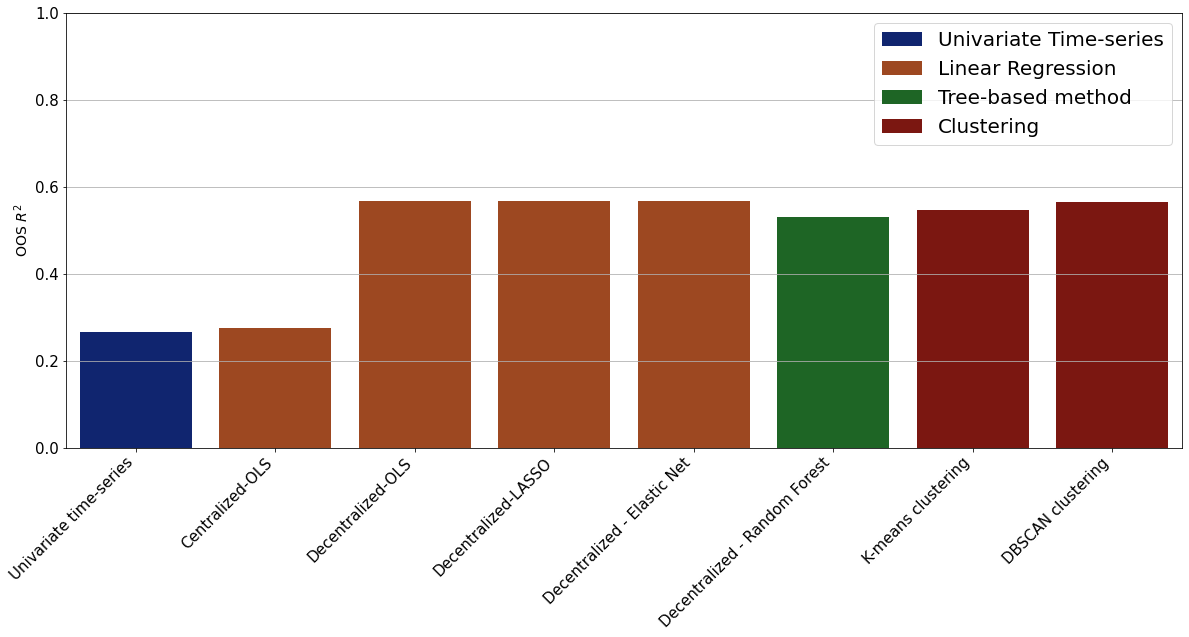

In [52]:
x_pos = np.arange(res.shape[1])

# Build the plot
#plt.figure(figsize=(20,8))
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylim([0,1])
g = sns.barplot(data=results, x='model', y='OOS R2', hue='model-type', ax=ax, dodge=False, palette='dark')
ax.legend(loc = 'upper right')
ax.set_ylabel('OOS $R^2$', size = 14)
ax.set_xlabel('')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Univariate time-series','Centralized-OLS','Decentralized-OLS','Decentralized-LASSO','Decentralized - Elastic Net',
                    'Decentralized - Random Forest',
                    'K-means clustering', 'DBSCAN clustering'],
                   rotation=45,ha='right')
ax.yaxis.grid(True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig("results_prophet.png",dpi=400, bbox_inches='tight')
plt.show()

## 2) Data Aggregation with Clustering

In [53]:
import pandas as pd
import numpy as np
sales=pd.read_csv('data_processed.csv')
sales.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Fonction DAC

In [54]:
from scipy.stats import norm
from sklearn.cluster import KMeans

In [55]:
def DAC(theta = 0.01, 
                    upp = 0.9, 
                    low = 0.1,
                    num_clusters = 9,
                    print_structure = False):
    
    d = len(colnames)
    n = len(skuSet)
    aggre_level = []
    clus_columns = []
    n_cols_alg = 0
    colnames_alg=[]
    z = num_clusters
    all_coeff = np.zeros((n,d))
    all_coeff[0,:] = skuModels[skuSet[0]].params

    for j in range(d): #d=number of features

        # a n-1 vector recording if two betas have the same mean
        test_j = np.zeros(n-1)

        for i in range(1,n): #n=number of features
            sku = skuSet[i]
            all_coeff[i,j] = skuModels[sku].params[j]

            z_stat = ( np.abs(skuModels[skuSet[0]].params[j] - skuModels[sku].params[j]) / 
                      np.sqrt(np.square(skuModels[skuSet[0]].bse[j]) + np.square(skuModels[sku].bse[j])) )
            p_value = 1 - norm.cdf(z_stat)
            if p_value >= theta:
                test_j[i-1] = 1

        if print_structure:
            print('Feature:', colnames[j])
            print('Ratio:', np.mean(test_j))

        if np.sum(test_j) >= upp*(n-1):
            aggre_level.append('dept')
            n_cols_alg += 1

        elif np.sum(test_j) <= low*(n-1):
            aggre_level.append('sku')
            n_cols_alg += n

        else:
            aggre_level.append('clus')
            clus_columns.append(j)
            n_cols_alg += z

        if print_structure:
            print(aggre_level[-1])
            print()

    if len(clus_columns) > 0:
        X_clus = all_coeff[:, clus_columns]
        kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

    X_alg_train = np.zeros((train_size, n_cols_alg))
    X_alg_test = np.zeros((test_size, n_cols_alg))

    count = 0
    for i in range(d):

        if aggre_level[i] == 'dept':

            for sku in skuSet:
                # find the corresponding range
                idx_train = range_dict[sku]['train']
                idx_test = range_dict[sku]['test']

                # stack the data
                X_alg_train[idx_train[0]:idx_train[1], count] = X_dict[sku]['train'][:,i]
                X_alg_test[idx_test[0]:idx_test[1], count] = X_dict[sku]['test'][:,i]

            count += 1
            colnames_alg.append(str(colnames[i+3])+'_dept')

        elif aggre_level[i] == 'clus':
            print(colnames[i])
            
            for j in range(z):
                # the indices of items in cluster j
                clus_items = list(np.where(kmeans.labels_ == j)[0])
                print(clus_items)
              
                for idx in clus_items:
                    sku = skuSet[idx]
                    # find the corresponding range
                    idx_train = range_dict[sku]['train']
                    idx_test = range_dict[sku]['test']

                    # stack the data
                    X_alg_train[idx_train[0]:idx_train[1], count] = X_dict[sku]['train'][:,i]
                    X_alg_test[idx_test[0]:idx_test[1], count] = X_dict[sku]['test'][:,i]

                count += 1
                colnames_alg.append(str(colnames[i])+get_str_list(clus_items))

        else:
            for sku in skuSet:
                # find the corresponding range
                idx_train = range_dict[sku]['train']
                idx_test = range_dict[sku]['test']

                # stack the data
                X_alg_train[idx_train[0]:idx_train[1], count] = X_dict[sku]['train'][:,i]
                X_alg_test[idx_test[0]:idx_test[1], count] = X_dict[sku]['test'][:,i]

                count += 1
                colnames_alg.append(str(colnames[i])+'_'+str(sku))
        
    return X_alg_train, X_alg_test, colnames_alg

In [56]:
def get_str_list(L):
  s=''
  for sku in L:
    s+='_'+str(sku)
  return s

### DAC - Linear

In [57]:
sales

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2018-08-27,44,20.0,53.99,42.38,43.99,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4308,2018-09-03,44,14.0,52.99,53.99,42.38,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4309,2018-09-10,44,22.0,44.99,52.99,53.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4310,2018-09-17,44,28.0,42.99,44.99,52.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [58]:
skuSet = list(sales.sku.unique())
skuData = {}
colnames = [i for i in sales.columns if i not in ["week","weekly_sales","sku"] ]
for i in skuSet:
  df_i = sales[sales.sku == i]
  skuData[i] = {'X': df_i[colnames].values,
                'y': df_i.weekly_sales.values}

In [59]:
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score

# testing data dictionary
X_dict = {}
y_dict = {}

skuModels = {}
y_pred = []
y_test = []
y_train = []


train_size = 0
test_size = 0
range_dict = {}
row_train = 0
row_test = 0

for i in skuSet:

    X_train_i,X_test_i = np.split(skuData[i]["X"], [68])
    y_train_i,y_test_i = np.split(skuData[i]["y"], [68])

    X_dict[i] = {'train': X_train_i, 'test': X_test_i}
    y_dict[i] = {'train': y_train_i, 'test': y_test_i}
    
    train_size += y_train_i.size
    test_size += y_test_i.size
    range_dict[i] = {'train': (row_train, row_train + y_train_i.size), 
                     'test':  (row_test, row_test + y_test_i.size) }
    
    row_train += y_train_i.size
    row_test += y_test_i.size
    
    model_i = OLS(y_train_i, X_train_i, hasconst = False)
    skuModels[i] = model_i.fit()
    y_pred += list(skuModels[i].predict(X_test_i))
    y_test += list(y_test_i)
    y_train += list(y_train_i)

y_train = np.array(y_train)
y_test = np.array(y_test)

print('R2:',r2_score(y_test, np.array(y_pred)))

R2: 0.5165391351359222


In [60]:
from sklearn.linear_model import LinearRegression

i=0
params=[]
maximum1=0

for upp in [0.7,0.8,0.9]:
    for low in [0.1,0.2,0.3]:
        for z in [6,7,8]:
          for theta in [0.01,0.05]:
            i+=1
            X_alg_train, X_alg_test, colnames_alg = DAC(upp = upp, low = low, num_clusters = z, theta=theta)
            print('Fitting model',i,'/54')
            model_0 = LinearRegression(fit_intercept=True).fit(X_alg_train, y_train)
            print('  Parameters:', upp, low, z, theta)
            score=r2_score(y_test, model_0.predict(X_alg_test))
            print('  R2 score:', str(score)[:5])
            if score>maximum1:
              params = [upp,low,z,theta]
              maximum1 = score

print('\nBest Model:')
print('Parameters:',params)
print('R2:',str(maximum1)[:5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
functionality_04.Selfie sticks
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
color_blue
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
vendor_6
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
vendor_8
[15, 33, 35]
[24]
[0, 1, 2, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
feat_main_page
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
vendor_10
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
Fitting model 2 /54
  Parameters: 0.7 0.1 6 0.05
  R2 score: 0.554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
feat_main_page
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
vendor_10
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
Fitting model 4 /54
  Parameters: 0.7 0.1 7 0.05
  R2 score: 0.554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
functionality_04.Selfie sticks
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
color_blue
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
vendor_6
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
vendor_8
[15, 33, 35]
[24]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
[14]
feat_main_page
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
[14]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
[14]
vendor_10
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10]
[22, 28, 29]
[39]
[14]
Fitting model 6 /54
  Parameters: 0.7 0.1 8 0.05
  R2 score: 0.564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
functionality_02.Portable smartphone chargers
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
Fitting model 7 /54
  Parameters: 0.7 0.2 6 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
Fitting model 8 /54
  Parameters: 0.7 0.2 6 0.05
  R2 score: 0.554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
functionality_02.Portable smartphone chargers
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
Fitting model 9 /54
  Parameters: 0.7 0.2 7 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
feat_main_page
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
Fitting model 10 /54
  Parameters: 0.7 0.2 7 0.05
  R2 score: 0.564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
Fitting model 11 /54
  Parameters: 0.7 0.2 8 0.01
  R2 score: 0.577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
feat_main_page
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
functionality_02.Portable smartphone chargers
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
Fitting model 12 /54
  Parameters: 0.7 0.2 8 0.05
  R2 score: 0.564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
functionality_02.Portable smartphone chargers
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
Fitting model 13 /54
  Parameters: 0.7 0.3 6 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[10, 22, 28, 29]
[39]
Fitting model 14 /54
  Parameters: 0.7 0.3 6 0.05
  R2 score: 0.554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
functionality_02.Portable smartphone chargers
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
Fitting model 15 /54
  Parameters: 0.7 0.3 7 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
feat_main_page
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[32]
[24]
[10, 22, 28, 29]
[14]
[39]
Fitting model 16 /54
  Parameters: 0.7 0.3 7 0.05
  R2 score: 0.564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
Fitting model 17 /54
  Parameters: 0.7 0.3 8 0.01
  R2 score: 0.577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
feat_main_page
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
functionality_02.Portable smartphone chargers
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 17, 18, 19, 21, 23, 26, 30, 31, 34, 36, 38, 40, 41, 42, 43]
[32]
[24]
[15, 33, 35]
[22, 28, 29]
[39]
[0, 5, 10, 11, 16, 20, 25, 27, 37]
[14]
Fitting model 18 /54
  Parameters: 0.7 0.3 8 0.05
  R2 score: 0.564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
functionality_04.Selfie sticks
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
color_blue
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
vendor_6
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[11, 14, 18, 29]
[32]
[10]
vendor_8
[15, 33, 35]
[24]
[0, 1, 2, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[6, 14, 33, 35, 39]
[24]
[32]
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 15]
[10]
feat_main_page
[6, 14, 33, 35, 39]
[24]
[32]
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 15]
[10]
month_10
[6, 14, 33, 35, 39]
[24]
[32]
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 15]
[10]
functionality_02.Portable smartphone chargers
[6, 14, 33, 35, 39]
[24]
[32]
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 15]
[10]
vendor_10
[6, 14, 33, 35, 39]
[24]
[32]
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 15]
[10]
Fitting model 20 /54
  Parameters: 0.8 0.1 6 0.05
  R2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[10]
[15, 33, 35]
[29]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[10]
[33, 35]
[8, 15]
[11, 22, 28, 29]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[10]
[33, 35]
[8, 15]
[11, 22, 28, 29]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[10]
[33, 35]
[8, 15]
[11, 22, 28, 29]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[10]
[33, 35]
[8, 15]
[11, 22, 28, 29]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[10]
[33, 35]
[8, 15]
[11, 22, 28, 29]
Fitting model 22 /54
  Parameters: 0.8 0.1 7 0.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
functionality_04.Selfie sticks
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
color_blue
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
vendor_6
[15, 33, 35]
[24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 26, 27, 28, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[32]
[10]
[11, 14, 18]
[0, 25, 30]
vendor_8
[15, 33, 35]
[24]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[33, 35]
[10]
[8, 15]
[11, 22, 28, 29]
[6, 14, 19, 39]
feat_main_page
[0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[33, 35]
[10]
[8, 15]
[11, 22, 28, 29]
[6, 14, 19, 39]
month_10
[0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[33, 35]
[10]
[8, 15]
[11, 22, 28, 29]
[6, 14, 19, 39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[33, 35]
[10]
[8, 15]
[11, 22, 28, 29]
[6, 14, 19, 39]
vendor_10
[0, 1, 2, 3, 4, 5, 7, 9, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[33, 35]
[10]
[8, 15]
[11, 22, 28, 29]
[6, 14, 19, 39]
Fitting model 24 /54
  Parameters: 0.8 0.1 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
functionality_02.Portable smartphone chargers
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
Fitting model 25 /54
  Parameters: 0.8 0.2 6 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
Fitting model 26 /54
  Parameters: 0.8 0.2 6 0.05
  R2 score: 0.541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
functionality_02.Portable smartphone chargers
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
Fitting model 27 /54
  Parameters: 0.8 0.2 7 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
feat_main_page
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
month_10
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
Fitting model 28 /54
  Parameters: 0.8 0.2 7 0.05
  R2 score: 0.550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
Fitting model 29 /54
  Parameters: 0.8 0.2 8 0.01
  R2 score: 0.577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
feat_main_page
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
month_10
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
Fitting model 30 /54
  Parameters: 0.8 0.2 8 0.05
  R2 score: 0.548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
functionality_02.Portable smartphone chargers
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
Fitting model 31 /54
  Parameters: 0.8 0.3 6 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 11, 22, 28, 29]
Fitting model 32 /54
  Parameters: 0.8 0.3 6 0.05
  R2 score: 0.541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
functionality_02.Portable smartphone chargers
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
Fitting model 33 /54
  Parameters: 0.8 0.3 7 0.01
  R2 score: 0.567


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
feat_main_page
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
month_10
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[8, 15]
[33, 35]
[10, 22, 28, 29]
[6, 14, 19, 27, 39]
Fitting model 34 /54
  Parameters: 0.8 0.3 7 0.05
  R2 score: 0.550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
Fitting model 35 /54
  Parameters: 0.8 0.3 8 0.01
  R2 score: 0.577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
feat_main_page
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
month_10
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 16, 17, 18, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 41, 42, 43]
[24]
[32]
[33, 35]
[6, 14, 19, 39]
[8, 15]
[22, 28, 29]
[11, 40]
Fitting model 36 /54
  Parameters: 0.8 0.3 8 0.05
  R2 score: 0.548


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[29]
[11, 14, 18]
month_5
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[29]
[11, 14, 18]
month_8
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[29]
[11, 14, 18]
month_10
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[29]
[11, 14, 18]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[29]
[11, 14, 18]
functionality_04.Selfie sticks
[15, 33, 35]
[24]
[0, 1, 2, 3, 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[32]
[33]
[8, 26, 29, 39]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[32]
[33]
[8, 26, 29, 39]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[32]
[33]
[8, 26, 29, 39]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[32]
[33]
[8, 26, 29, 39]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[32]
[33]
[8, 26, 29, 39]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[29]
[15, 33, 35]
[8, 26, 28, 39]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[29]
[15, 33, 35]
[8, 26, 28, 39]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[29]
[15, 33, 35]
[8, 26, 28, 39]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[29]
[15, 33, 35]
[8, 26, 28, 39]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[11, 14, 18]
[32]
[29]
[15, 33, 35]
[8, 26, 28, 39]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 9,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[32]
[11, 14, 18]
[8, 26, 28, 39]
[15, 33, 35]
[10]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[32]
[11, 14, 18]
[8, 26, 28, 39]
[15, 33, 35]
[10]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[32]
[11, 14, 18]
[8, 26, 28, 39]
[15, 33, 35]
[10]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[32]
[11, 14, 18]
[8, 26, 28, 39]
[15, 33, 35]
[10]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[32]
[11, 14, 18]
[8, 26, 28, 39]
[15, 33, 35]
[10]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[14]
[26, 29, 39]
[33]
[11, 22, 40]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[14]
[26, 29, 39]
[33]
[11, 22, 40]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[14]
[26, 29, 39]
[33]
[11, 22, 40]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[14]
[26, 29, 39]
[33]
[11, 22, 40]
[8]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[14]
[26, 29, 39]
[33]
[11, 22, 40]
[8]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
Fitting model 43 /54
  Parameters: 0.9 0.2 6 0.01
  R2 score: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
month_6
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_5
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_8
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_10
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
Fitting model 45 /54
  Parameters: 0.9 0.2 7 0.01
  R2 sco

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
Fitting model 47 /54
  Parameters: 0.9 0.2 8 0.01
  R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[8, 26, 28, 39]
[14, 15, 33, 35]
Fitting model 49 /54
  Parameters: 0.9 0.3 6 0.01
  R2 score: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[14]
[8]
[26, 29, 39]
month_6
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_5
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_8
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
month_10
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
functionality_02.Portable smartphone chargers
[15, 33, 35]
[24]
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[8, 26, 39]
[14]
[29]
Fitting model 51 /54
  Parameters: 0.9 0.3 7 0.01
  R2 sco

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[8]
[33]
[14]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[32]
[29]
[26, 28, 39]
[14]
[8, 15]
[33, 35]
Fitting model 53 /54
  Parameters: 0.9 0.3 8 0.01
  R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 42, 43]
[24]
[32]
[26, 29, 39]
[33]
[14]
[11, 22, 40]
[8]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27,

In [61]:
X_alg_train, X_alg_test, colnames_alg = DAC(upp = 0.7, low = 0.2, num_clusters = 8, theta=0.01, print_structure=True)
print('Fitting model',i,'/54')
model_0 = LinearRegression(fit_intercept=True).fit(X_alg_train, y_train)
score=r2_score(y_test, model_0.predict(X_alg_test))
print('  R2 score:', str(score)[:5])

Feature: price
Ratio: 0.5581395348837209
clus

Feature: price-1
Ratio: 0.9302325581395349
dept

Feature: price-2
Ratio: 0.9069767441860465
dept

Feature: feat_main_page
Ratio: 0.9534883720930233
dept

Feature: trend
Ratio: 0.9069767441860465
dept

Feature: month_2
Ratio: 1.0
dept

Feature: month_3
Ratio: 0.9767441860465116
dept

Feature: month_4
Ratio: 0.9302325581395349
dept

Feature: month_5
Ratio: 0.8604651162790697
dept

Feature: month_6
Ratio: 0.9069767441860465
dept

Feature: month_7
Ratio: 0.9069767441860465
dept

Feature: month_8
Ratio: 0.8837209302325582
dept

Feature: month_9
Ratio: 0.9534883720930233
dept

Feature: month_10
Ratio: 0.8837209302325582
dept

Feature: month_11
Ratio: 0.9302325581395349
dept

Feature: month_12
Ratio: 0.9534883720930233
dept

Feature: functionality_02.Portable smartphone chargers
Ratio: 0.6046511627906976
clus

Feature: functionality_03.Bluetooth speakers
Ratio: 0.023255813953488372
sku

Feature: functionality_04.Selfie sticks
Ratio: 0.11627906976

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



Feature: vendor_4
Ratio: 0.023255813953488372
sku

Feature: vendor_5
Ratio: 0.023255813953488372
sku

Feature: vendor_6
Ratio: 0.13953488372093023
sku

Feature: vendor_7
Ratio: 0.023255813953488372
sku

Feature: vendor_8
Ratio: 0.11627906976744186
sku

Feature: vendor_9
Ratio: 0.046511627906976744
sku

Feature: vendor_10
Ratio: 0.13953488372093023
sku

price
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
functionality_02.Portable smartphone chargers
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[35]
[14, 29]
[15]
[34]
[32]
[33]
Fitting model 54 /54
  R2 score: 0.577


In [62]:
import time

In [63]:
z = 7
upp, low = 0.7, 0.2
theta=0.01
tZero=time.time()
X_alg_train, X_alg_test, colnames_alg = DAC(upp = upp, low = low, 
                                          num_clusters = z, theta=theta,
                                          print_structure = True)

print('Fitting model...')
model_0 = LinearRegression().fit(X_alg_train, y_train)
print('Parameters:', upp, low, z, theta) 
print('R2 score:', r2_score(y_test, model_0.predict(X_alg_test)))
t = time.time()-tZero
print("time to compute",t)

Feature: price
Ratio: 0.5581395348837209
clus

Feature: price-1
Ratio: 0.9302325581395349
dept

Feature: price-2
Ratio: 0.9069767441860465
dept

Feature: feat_main_page
Ratio: 0.9534883720930233
dept

Feature: trend
Ratio: 0.9069767441860465
dept

Feature: month_2
Ratio: 1.0
dept

Feature: month_3
Ratio: 0.9767441860465116
dept

Feature: month_4
Ratio: 0.9302325581395349
dept

Feature: month_5
Ratio: 0.8604651162790697
dept

Feature: month_6
Ratio: 0.9069767441860465
dept

Feature: month_7
Ratio: 0.9069767441860465
dept

Feature: month_8
Ratio: 0.8837209302325582
dept

Feature: month_9
Ratio: 0.9534883720930233
dept

Feature: month_10
Ratio: 0.8837209302325582
dept

Feature: month_11
Ratio: 0.9302325581395349
dept

Feature: month_12
Ratio: 0.9534883720930233
dept

Feature: functionality_02.Portable smartphone chargers
Ratio: 0.6046511627906976
clus

Feature: functionality_03.Bluetooth speakers
Ratio: 0.023255813953488372
sku

Feature: functionality_04.Selfie sticks
Ratio: 0.11627906976

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



Feature: color_white
Ratio: 0.046511627906976744
sku

Feature: vendor_2
Ratio: 0.023255813953488372
sku

Feature: vendor_3
Ratio: 0.023255813953488372
sku

Feature: vendor_4
Ratio: 0.023255813953488372
sku

Feature: vendor_5
Ratio: 0.023255813953488372
sku

Feature: vendor_6
Ratio: 0.13953488372093023
sku

Feature: vendor_7
Ratio: 0.023255813953488372
sku

Feature: vendor_8
Ratio: 0.11627906976744186
sku

Feature: vendor_9
Ratio: 0.046511627906976744
sku

Feature: vendor_10
Ratio: 0.13953488372093023
sku

price
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
functionality_02.Portable smartphone chargers
[35]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29, 32]
[34]
[15]
[33]
Fitting model...
Parameters: 0.7 0.2 7 0.01
R2 score: 0.5676202783573727
time to compute 1.

### DAC - Log-linear

In [64]:
sales['price']=np.log(sales['price'])
sales['price-1']=np.log(sales['price-1'])
sales['price-2']=np.log(sales['price-2'])
sales.head()

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,2.326302,2.288486,2.318458,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,2.112635,2.326302,2.288486,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,2.178155,2.112635,2.326302,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,2.195000,2.178155,2.112635,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,2.341806,2.195000,2.178155,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [65]:
skuSet = list(sales.sku.unique())
skuData = {}
colnames = [i for i in sales.columns if i not in ["week","weekly_sales","sku"] ]
for i in skuSet:
  df_i = sales[sales.sku == i]
  skuData[i] = {'X': df_i[colnames].values,
                'y': df_i.weekly_sales.values}

In [66]:
# testing data dictionary
X_dict = {}
y_dict = {}

skuModels = {}
y_pred = []
y_test = []
y_train = []


train_size = 0
test_size = 0
range_dict = {}
row_train = 0
row_test = 0

for i in skuSet:

    X_train_i,X_test_i = np.split(skuData[i]["X"], [68])
    y_train_i,y_test_i = np.split(skuData[i]["y"], [68])

    X_dict[i] = {'train': X_train_i, 'test': X_test_i}
    y_dict[i] = {'train': y_train_i, 'test': y_test_i}
    
    train_size += y_train_i.size
    test_size += y_test_i.size
    range_dict[i] = {'train': (row_train, row_train + y_train_i.size), 
                     'test':  (row_test, row_test + y_test_i.size) }
    
    row_train += y_train_i.size
    row_test += y_test_i.size
    
    model_i = OLS(y_train_i, X_train_i, hasconst = False)
    skuModels[i] = model_i.fit()
    y_pred += list(skuModels[i].predict(X_test_i))
    y_test += list(y_test_i)
    y_train += list(y_train_i)

y_train = np.array(y_train)
y_test = np.array(y_test)

print('R2:',r2_score(y_test, np.array(y_pred)))

R2: 0.558297423402921


In [67]:
i=0
params=[]
maximum1=0

for upp in [0.7,0.8,0.9]:
    for low in [0.1,0.2,0.3]:
        for z in [7,8,9]:
          for theta in [0.01,0.05,0.1]:
            i+=1
            X_alg_train, X_alg_test, colnames_alg = DAC(upp = upp, low = low, num_clusters = z, theta=theta)
            print('Fitting model',i,'/81')
            model_0 = LinearRegression().fit(X_alg_train, y_train)
            print('  Parameters:', upp, low, z)
            score=r2_score(y_test, model_0.predict(X_alg_test))
            print('  R2 score:', score)
            if score>maximum1:
              params = [upp,low,z,theta]
              maximum1 = score

print('\nBest Model:')
print('Parameters:',params)
print('R2:',maximum1)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
functionality_09.Smartphone stands
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[11, 15, 18, 33, 35]
[24]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[14, 29]
[10]
[8, 32]
[0, 6, 7, 12, 13, 16, 19, 22, 25, 26, 27, 28, 30, 34, 39, 40]
vendor_10
[11, 15, 18, 33, 35]
[24]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[14, 29]
[10]
[8, 32]
[0, 6, 7, 12, 13, 16, 19, 22, 25, 26, 27, 28, 30, 34, 39, 40]
Fitting model 2 /81
  Parameters: 0.7 0.1 7
  R2 score: 0.6113836902978617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
price-2
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
feat_main_page
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
vendor_10
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
Fitting model 3 /81
  Parameters: 0.7 0.1 7
  R2 score: 0.601859616731308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
functionality_04.Selfie sticks
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
functionality_09.Smartphone stands
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
color_blue
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
vendor_6
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
vendor_8
[33, 35]
[24]
[0, 1, 2, 3, 4,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 9, 16, 17, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[15, 18, 33, 35]
[8, 32]
[11, 19, 28]
[7, 12, 13]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 9, 16, 17, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[15, 18, 33, 35]
[8, 32]
[11, 19, 28]
[7, 12, 13]
Fitting model 5 /81
  Parameters: 0.7 0.1 8
  R2 score: 0.6090463318845176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[11, 15, 28]
[10]
[32]
[29]
[8, 18, 33, 35]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[11, 15, 28]
[10]
[32]
[29]
[8, 18, 33, 35]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[11, 15, 28]
[10]
[32]
[29]
[8, 18, 33, 35]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[11, 15, 28]
[10]
[32]
[29]
[8, 18, 33, 35]
Fitting model 6 /81
  Parameters: 0.7 0.1 8
  R2 score: 0.6002613351491288


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
functionality_09.Smartphone stands
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14, 29]
[7, 12, 13]
[24]
[10]
[15, 18, 33, 35]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[8, 32]
[0, 6, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[11, 19, 28]
vendor_10
[14, 29]
[7, 12, 13]
[24]
[10]
[15, 18, 33, 35]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[8, 32]
[0, 6, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[11, 19, 28]
Fitting model 8 /81
  Parameters: 0.7 0.1 9
  R2 score: 0.6108883577001404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 18, 33, 35]
[32]
[14]
[15]
[11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 18, 33, 35]
[32]
[14]
[15]
[11, 26, 28]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 18, 33, 35]
[32]
[14]
[15]
[11, 26, 28]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 18, 33, 35]
[32]
[14]
[15]
[11, 26, 28]
Fitting model 9 /81
  Parameters: 0.7 0.1 9
  R2 score: 0.6067218512784261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 10 /81
  Parameters: 0.7 0.2 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 11 /81
  Parameters: 0.7 0.2 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
Fitting model 12 /81
  Parameters: 0.7 0.2 7
  R2 score: 0.6002491751062471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 13 /81
  Parameters: 0.7 0.2 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 14 /81
  Parameters: 0.7 0.2 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
Fitting model 15 /81
  Parameters: 0.7 0.2 8
  R2 score: 0.6070638238691406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 16 /81
  Parameters: 0.7 0.2 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 17 /81
  Parameters: 0.7 0.2 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
Fitting model 18 /81
  Parameters: 0.7 0.2 9
  R2 score: 0.6066691432366951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 19 /81
  Parameters: 0.7 0.3 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 20 /81
  Parameters: 0.7 0.3 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[32]
[8, 18, 33, 35]
[11, 15, 28]
Fitting model 21 /81
  Parameters: 0.7 0.3 7
  R2 score: 0.6002491751062471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 22 /81
  Parameters: 0.7 0.3 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 23 /81
  Parameters: 0.7 0.3 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[8, 18, 33, 35]
[29]
[32]
[15]
[10, 11, 26, 28]
Fitting model 24 /81
  Parameters: 0.7 0.3 8
  R2 score: 0.6070638238691406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 25 /81
  Parameters: 0.7 0.3 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 26 /81
  Parameters: 0.7 0.3 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[32]
[14]
[11, 26, 28]
[10, 19]
[15]
Fitting model 27 /81
  Parameters: 0.7 0.3 9
  R2 score: 0.6066691432366951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
functionality_09.Smartphone stands
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[10]
[32, 33, 35]
[11, 18]
[8, 15]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
Fitting model 29 /81
  Parameters: 0.8 0.1 7
  R2 score: 0.5994623166252834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
price-1
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
price-2
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
feat_main_page
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
trend
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
month_5
[8, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
functionality_04.Selfie sticks
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
functionality_09.Smartphone stands
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
color_blue
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
vendor_6
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[10]
[11, 18]
[32]
[8, 15]
vendor_8
[33, 35]
[24]
[0, 1, 2, 3, 4,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[8, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
[15]
price-2
[8, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
[15]
month_10
[8, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
[15]
vendor_10
[8, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[10]
[14]
[32]
[15]
Fitting model 32 /81
  Parameters: 0.8 0.1 8
  R2 score: 0.6012887944812046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 15, 18, 33, 35]
[32]
[29]
[10]
[8]
price-1
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 15, 18, 33, 35]
[32]
[29]
[10]
[8]
price-2
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 15, 18, 33, 35]
[32]
[29]
[10]
[8]
feat_main_page
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 15, 18, 33, 35]
[32]
[29]
[10]
[8]
trend
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 15, 18, 33, 35]
[32]
[29]
[10]
[8]
month_5
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
functionality_04.Selfie sticks
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
functionality_09.Smartphone stands
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
color_blue
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
vendor_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14, 29]
[11, 18]
[8, 15]
[10]
[32]
[33, 35]
[28]
vendor_8
[0, 1, 2, 3, 4, 5, 6, 7,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[10]
[14]
[32]
[15]
[11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[10]
[14]
[32]
[15]
[11, 26, 28]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[10]
[14]
[32]
[15]
[11, 26, 28]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[10]
[14]
[32]
[15]
[11, 26, 28]
Fitting model 35 /81
  Parameters: 0.8 0.1 9
  R2 score: 0.6035981658206817


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
[22, 28]
[8]
price-1
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
[22, 28]
[8]
price-2
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
[22, 28]
[8]
feat_main_page
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
[22, 28]
[8]
trend
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[10]
[29]
[22, 28]
[8]
month_5
[11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 37 /81
  Parameters: 0.8 0.2 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
Fitting model 38 /81
  Parameters: 0.8 0.2 7
  R2 score: 0.6015419185614547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 40 /81
  Parameters: 0.8 0.2 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
Fitting model 41 /81
  Parameters: 0.8 0.2 8
  R2 score: 0.60537120037221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 43 /81
  Parameters: 0.8 0.2 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
price-2
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
month_10
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
Fitting model 44 /81
  Parameters: 0.8 0.2 9
  R2 score: 0.6042105474632897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8, 32]
[14, 29]
[15, 18, 33, 35]
[10, 11, 19, 28]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
Fitting model 46 /81
  Parameters: 0.8 0.3 7
  R2 score: 0.6112286875787976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8, 18, 33, 35]
[15]
[32]
Fitting model 47 /81
  Parameters: 0.8 0.3 7
  R2 score: 0.6015419185614547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[29]
[8]
[10, 11, 15, 18, 19, 33, 35]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[15, 18, 33, 35]
[24]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[14, 29]
[8]
[10, 11, 19, 28]
[32]
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
Fitting model 49 /81
  Parameters: 0.8 0.3 8
  R2 score: 0.6116293353694444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[8, 18, 33, 35]
[14]
[32]
[15]
[10, 11, 26, 28]
Fitting model 50 /81
  Parameters: 0.8 0.3 8
  R2 score: 0.60537120037221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[29]
[14]
[8]
[11, 15, 18, 33, 35]
[26, 28, 39]
month_5
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[1, 2, 3, 4, 5, 9, 17, 20, 21, 23, 31, 36, 37, 38, 41, 42, 43]
[24]
[8]
[14, 29]
[10, 11]
[15, 18, 33, 35]
[0, 6, 7, 12, 13, 16, 22, 25, 26, 27, 30, 34, 39, 40]
[32]
[19, 28]
Fitting model 52 /81
  Parameters: 0.8 0.3 9
  R2 score: 0.6113944120804469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
price-2
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
month_10
[10, 18, 19, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[29]
[14]
[32]
[15]
[8]
[11, 26, 28]
Fitting model 53 /81
  Parameters: 0.8 0.3 9
  R2 score: 0.6042105474632897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[10, 11, 18, 19, 33, 35]
[22, 28]
[15]
[8]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 23, 25, 26, 27, 30, 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[32]
[11, 18]
[10]
price-1
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[32]
[11, 18]
[10]
price-2
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[32]
[11, 18]
[10]
month_5
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[32]
[11, 18]
[10]
month_6
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[14, 29]
[32]
[11, 18]
[10]
month_8
[33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
price-1
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
price-2
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
feat_main_page
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
trend
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
month_3
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
price-1
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
price-2
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
feat_main_page
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
trend
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[32]
[10]
[14]
month_3
[8, 33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[8, 15, 33, 35]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[8, 15, 33, 35]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[8, 15, 33, 35]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[8, 15, 33, 35]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[8, 15, 33, 35]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[29]
[14]
[10]
[8]
price-1
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[29]
[14]
[10]
[8]
price-2
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[29]
[14]
[10]
[8]
feat_main_page
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[29]
[14]
[10]
[8]
trend
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[29]
[14]
[10]
[8]
month_3
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[10]
[29]
[8]
price-1
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[10]
[29]
[8]
price-2
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[10]
[29]
[8]
feat_main_page
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[10]
[29]
[8]
trend
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[10]
[29]
[8]
month_3
[33, 35]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[33, 35]
[8, 15]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[33, 35]
[8, 15]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[33, 35]
[8, 15]
month_5
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[33, 35]
[8, 15]
month_6
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[11, 18]
[32]
[14]
[10]
[29]
[33, 35]
[8, 15]
month_8
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10]
[29]
[8]
[33, 35]
[11, 15]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
price-1
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
price-2
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_5
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_6
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_8
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
price-1
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
price-2
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_5
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_6
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_8
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
month_3
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
price-1
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
price-2
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_5
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_6
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_8
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
price-1
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
price-2
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
feat_main_page
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
trend
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
month_3
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
price-1
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
price-2
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_5
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_6
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[32]
[14]
[8]
[29]
month_8
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[32]
[14]
[33, 35]
[29]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
price-1
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
price-2
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_5
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_6
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[24]
[10, 11, 15, 18, 33, 35]
[32]
[22, 26, 28, 39]
[29]
[8]
month_8
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
price-1
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
price-2
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
feat_main_page
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
trend
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[14]
[33, 35]
[8]
[11, 15, 18]
month_3
[32]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[10, 11, 15, 18, 26, 28]
[29]
[33, 35]
[8]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 27, 30, 31,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
price-1
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
price-2
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_5
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_6
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 20, 21, 23, 25, 27, 30, 31, 34, 36, 37, 38, 40, 41, 42, 43]
[29]
[32]
[14]
[8]
[26, 39]
[22, 28]
month_8
[10, 11, 15, 18, 33, 35]
[24]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 19, 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
price-1
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
feat_main_page
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
trend
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[14]
[32]
[29]
[33, 35]
[15]
[8]
[10, 11, 18, 19]
month_3
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 16, 17, 20, 21, 22, 23, 25, 26, 27, 28

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
price-1
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
price-2
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
feat_main_page
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
trend
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[33, 35]
[32]
[8]
[22]
[29]
[11, 15]
month_3
[14]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 23, 2

In [68]:
z = 7
upp, low = 0.8, 0.1
theta=0.05
X_alg_train, X_alg_test, colnames_alg = DAC(upp = upp, low = low, 
                                          num_clusters = z, theta=theta,
                                          print_structure = False)
# When print structure use seed = 2
print('Fitting model...')

model_0 = LinearRegression().fit(X_alg_train, y_train)
print('Parameters:', upp, low, z, theta) 
print('R2 score:', r2_score(y_test, model_0.predict(X_alg_test)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

invalid value encountered in double_scalars



price
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
price-2
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
month_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
vendor_10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43]
[24]
[29]
[10]
[8, 15, 18, 33, 35]
[32]
[14]
Fitting model...
Parameters: 0.8 0.1 7 0.05
R2 score: 0.5994623166252834


In [69]:
res['DAC_log_lin']=[r2_score(y_test, model_0.predict(X_alg_test))]
res

,univariate,centralized,decentralized,decentralized_lasso,decentralized_elasticnet,decentralized-RF,K-means,DBSCAN,DAC_log_lin
0,0.265396,0.274786,0.565798,0.566411,0.567848,0.530509,0.545038,0.564908,0.599462
